# Main of the paper - logistic

In this notebook are gathered all experiments generated for the main of the paper which requires logistic regression.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "logistic"

nb_devices_for_the_run = 10
dim_notebook = 2
MAX_NB_DEVICES = 40

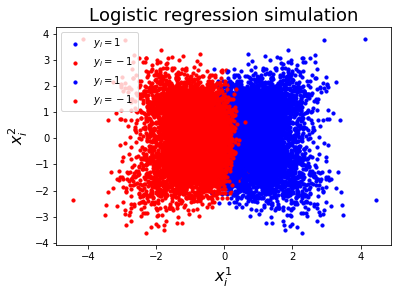

In [2]:
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10.0, 0.0]).to(dtype=torch.float64)
X_check, Y_check = build_data_logistic(w_true, n_samples = 10000, n_dimensions = dim_notebook, n_devices=10, with_seed=False)

logistic_plot(X_check[0], Y_check[0])
logistic_plot(X_check[1], Y_check[1])
plt.show()

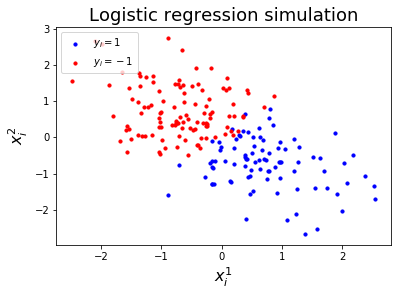

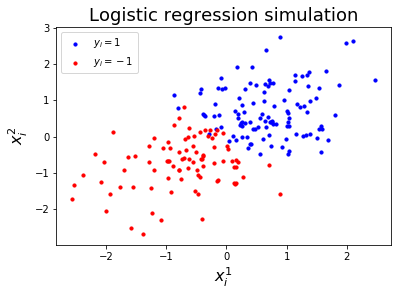

In [3]:
#w = torch.FloatTensor([0, 1000]).to(dtype=torch.float64) # Same w but different distribution (remove w modif)
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10, 0]).to(dtype=torch.float64)
X, Y = build_data_logistic(w, n_dimensions = dim_notebook,
                                             n_devices=nb_devices_for_the_run, with_seed=False)
pickle_saver((X, Y), filename + "-data")
for i in range(0, 2, 1):
    logistic_plot(X[i], Y[i])
    plt.show()

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=20000, 
                                                     quantization_param=0, 
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
pickle_saver(obj_min_by_N_descent.losses[-1], filename + "-obj_min")



   it    |   obj   
    4000 | 3.0774e-01
    8000 | 3.0774e-01
   12000 | 3.0774e-01
   16000 | 3.0774e-01
Gradient Descent: execution time=52.054 seconds
Final loss : 0.30774

CPU times: user 52 s, sys: 28 ms, total: 52.1 s
Wall time: 52.1 s


In [6]:
obj_min_by_N_descent.model_params[-1]

tensor([ 3.6963, -0.0044], dtype=torch.float64)

In [12]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, use_averaging=True, 
                                               step_formula=deacreasing_step_size)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 6/6 [02:32<00:00, 25.37s/it]

CPU times: user 2min 32s, sys: 32 ms, total: 2min 32s
Wall time: 2min 32s


# With averaging

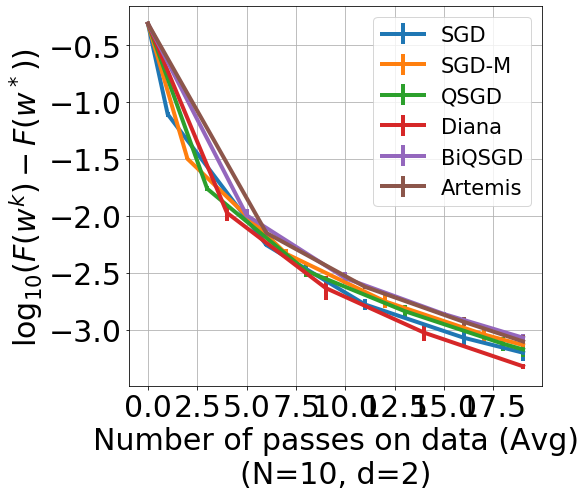

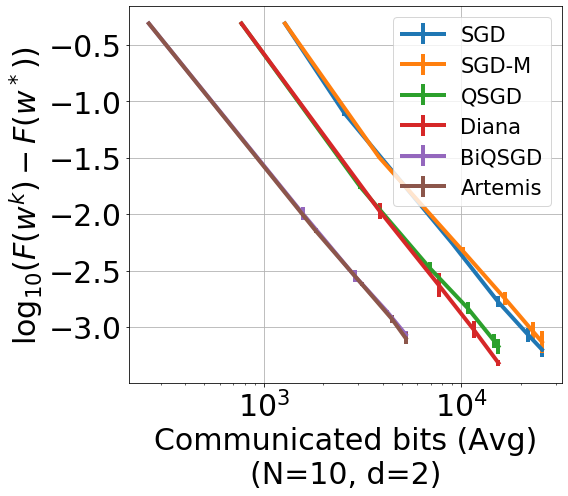

In [13]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Without averaging

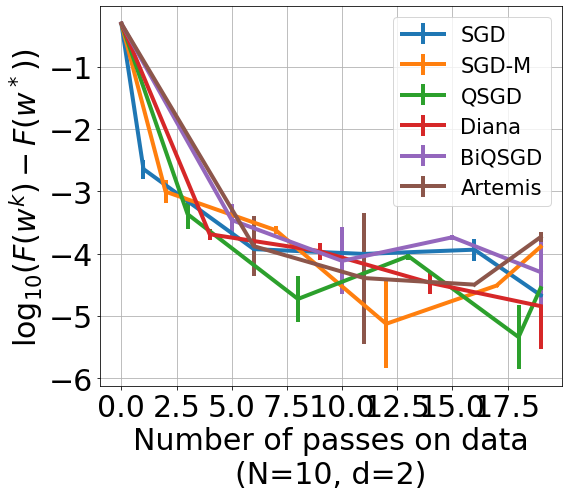

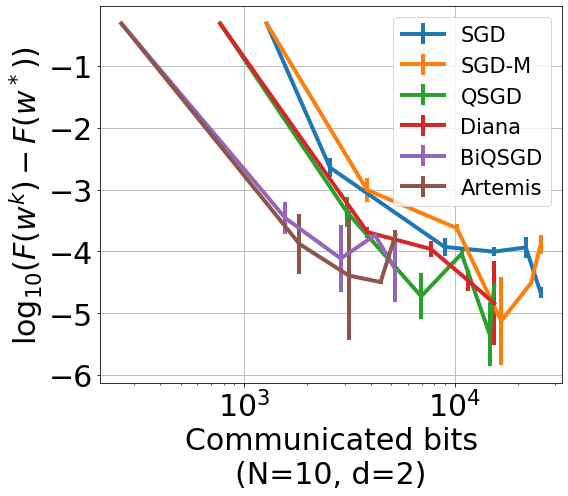

In [14]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
